In [98]:
# importing general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [99]:
# dataset paths
data_path1 = '../Part_1/Data/data0.npy'
data_path2 = '../Part_1/Data/data1.npy'
data_path3 = '../Part_1/Data/data2.npy'

label_path1 = '../Part_1/Data/lab0.npy'
label_path2 = '../Part_1/Data/lab1.npy'
label_path3 = '../Part_1/Data/lab2.npy'

In [100]:
# loading the dataset
data1 = np.load(data_path1)
data2 = np.load(data_path2)
data3 = np.load(data_path3)

label1 = np.load(label_path1)
label2 = np.load(label_path2)
label3 = np.load(label_path3)

In [101]:
# printing the shape of the data
print('Data1 shape:', data1.shape, 'Label1 shape:', label1.shape)
print('Data2 shape:', data2.shape, 'Label2 shape:', label2.shape)
print('Data3 shape:', data3.shape, 'Label3 shape:', label3.shape)


Data1 shape: (10000, 40, 168) Label1 shape: (10000,)
Data2 shape: (10000, 40, 168) Label2 shape: (10000,)
Data3 shape: (10000, 40, 168) Label3 shape: (10000,)


In [102]:
# combining the datasets into 1
data = np.concatenate((data1, data2, data3), axis=0)
labels = np.concatenate((label1, label2, label3), axis=0)
print('Data shape:', data.shape, 'Labels shape:', labels.shape)

Data shape: (30000, 40, 168) Labels shape: (30000,)


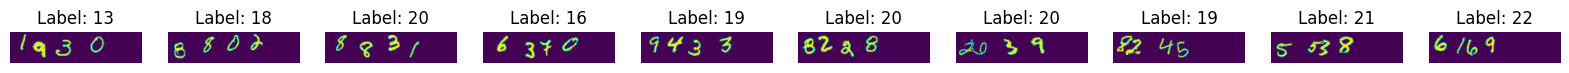

In [103]:
# displaying random images from the dataset
def display_images(data, label, indexes):
    fig, axes = plt.subplots(1, len(indexes), figsize=(20, 20))
    for i, j in enumerate(indexes):
        axes[i].imshow(data[j])
        axes[i].set_title('Label: ' + str(label[j]))
        axes[i].axis('off')
    plt.show()

num_images = 10
indexes = np.random.randint(0, data.shape[0], num_images)
display_images(data, labels, indexes)

In [104]:
# splitting the data into training and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
print('X_train shape:', X_train.shape, 'y_train shape:', y_train.shape)
print('X_val shape:', X_val.shape, 'y_val shape:', y_val.shape)

X_train shape: (24000, 40, 168) y_train shape: (24000,)
X_val shape: (6000, 40, 168) y_val shape: (6000,)


In [105]:
# making dataloader for the dataset
import torch
from torch.utils.data import Dataset, DataLoader

# Custom Dataset
class SumDigitsDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# creating the dataset
train_dataset = SumDigitsDataset(X_train, y_train)
val_dataset = SumDigitsDataset(X_val, y_val)

# creating the dataloaders
train_batch_size = 32
val_batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)

In [106]:
# defining the baseline model
import torch 
import torch.nn as nn
import torch.nn.functional as F

class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # (40, 168) -> (40, 168)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (40, 168) -> (20, 84)

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (20, 84) -> (20, 84)
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # (20, 84) -> (10, 42)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 10 * 42, 128),  # Fully connected layer
            nn.ReLU(),
            nn.Linear(128, 1)  # Output layer
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [107]:
# training the model
epochs = 30
learning_rate = 0.001
critereon = nn.MSELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BaselineCNN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss = []
val_loss = []

for epoch in range(epochs):
    print('Epoch:', epoch+1)

    print('Training...', end='\n')
    model.train()
    running_train_loss = 0
    training_batches = len(train_dataloader)
    for i, (images, labels) in enumerate(train_dataloader):
        print('Batch:', i+1, "out of", training_batches, end='\r')
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.squeeze(1)
        loss = critereon(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_loss.append(running_train_loss/len(train_dataloader))

    print('Validating...', end='\n')
    model.eval()
    running_val_loss = 0
    validation_batches = len(val_dataloader)
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_dataloader):
            print('Batch:', i+1, "out of", validation_batches, end='\r')
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.squeeze(1)
            loss = critereon(outputs, labels)
            running_val_loss += loss.item()
        val_loss.append(running_val_loss/len(val_dataloader))

    print('Epoch: {}/{} Train Loss: {:.4f} Val Loss: {:.4f}'.format(epoch+1, epochs, train_loss[-1], val_loss[-1]))

    # saving the best model
    if epoch == 0:
        best_val_loss = val_loss[-1]
        torch.save(model.state_dict(), 'baseline_model.pth')
    else:
        if val_loss[-1] < best_val_loss:
            best_val_loss = val_loss[-1]
            torch.save(model.state_dict(), 'baseline_model.pth')

Epoch: 1
Training...
Validating...t of 750
Epoch: 1/30 Train Loss: 96.0844 Val Loss: 26.1571
Epoch: 2
Training...
Validating...t of 750
Epoch: 2/30 Train Loss: 22.2178 Val Loss: 20.5652
Epoch: 3
Training...
Validating...t of 750
Epoch: 3/30 Train Loss: 18.1961 Val Loss: 18.7181
Epoch: 4
Training...
Validating...t of 750
Epoch: 4/30 Train Loss: 15.5361 Val Loss: 17.1721
Epoch: 5
Training...
Validating...t of 750
Epoch: 5/30 Train Loss: 14.0636 Val Loss: 19.6707
Epoch: 6
Training...
Validating...t of 750
Epoch: 6/30 Train Loss: 12.7029 Val Loss: 15.4547
Epoch: 7
Training...
Validating...t of 750
Epoch: 7/30 Train Loss: 11.7635 Val Loss: 14.6505
Epoch: 8
Training...
Validating...t of 750
Epoch: 8/30 Train Loss: 10.9226 Val Loss: 13.5955
Epoch: 9
Training...
Validating...t of 750
Epoch: 9/30 Train Loss: 10.4246 Val Loss: 14.1792
Epoch: 10
Training...
Validating...t of 750
Epoch: 10/30 Train Loss: 9.8044 Val Loss: 13.1362
Epoch: 11
Training...
Validating...t of 750
Epoch: 11/30 Train Loss: 

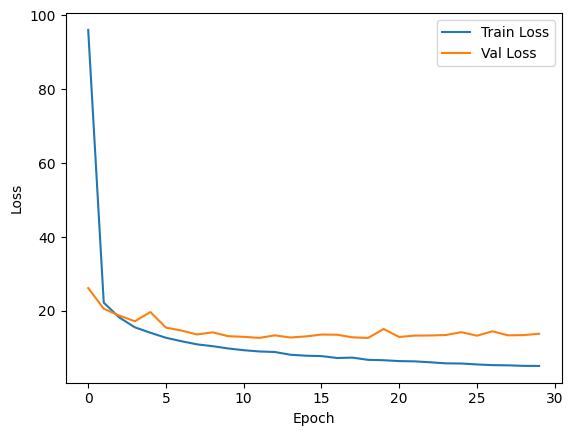

In [108]:
# plotting the loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()